In [1]:
!pip install tensorflow

In [2]:
!pip install tensorflow_datasets

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt


In [4]:
# Obtain the imdb review dataset from tensorflow datasets
dataset = tfds.load('imdb_reviews', as_supervised=True)

# Seperate test and train datasets
train_dataset, test_dataset = dataset['train'], dataset['test']

# Split the test and train data into batches of 32
# and shuffling the training set
batch_size = 32
train_dataset = train_dataset.shuffle(10000)
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


In [5]:
#iter function to create an iterator for the training dataset and then extracts the first batch
example, label = next(iter(train_dataset))
print('Text:\n', example.numpy()[0])
print('\nLabel: ', label.numpy()[0])


Text:
 b"Love this film also. Saw it when it was first shown i8n Germany in a small independent cinema in Frankfurt. It was really crowded and it was a very ambitious atmosphere to. The erotic of the movie hit the spectators and the discussion with Moritz Boerner the producer and director was always underlined by that. In his genre it was a very ambitious movie even especially when you think that it was an independent movie.<br /><br />It doesn't exist much copies of that film, Mortitz Boerner came from the theatre and made two or three short movies more worked for TV as well before he became a sort of therapist.<br /><br />For the people who wish to see that movie again, you could find it on his homepage which isn't that easy to search for but its possible."

Label:  1


In [6]:
# Using the TextVectorization layer to normalize, split, and map strings
# to integers.
encoder = tf.keras.layers.TextVectorization(max_tokens=10000)
encoder.adapt(train_dataset.map(lambda text, _: text))

# Extracting the vocabulary from the TextVectorization layer.
vocabulary = np.array(encoder.get_vocabulary())

# Encoding a test example and decoding it back.
original_text = example.numpy()[0]
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocabulary[encoded_text])

print('original: ', original_text)
print('encoded: ', encoded_text)
print('decoded: ', decoded_text)

original:  b"Love this film also. Saw it when it was first shown i8n Germany in a small independent cinema in Frankfurt. It was really crowded and it was a very ambitious atmosphere to. The erotic of the movie hit the spectators and the discussion with Moritz Boerner the producer and director was always underlined by that. In his genre it was a very ambitious movie even especially when you think that it was an independent movie.<br /><br />It doesn't exist much copies of that film, Mortitz Boerner came from the theatre and made two or three short movies more worked for TV as well before he became a sort of therapist.<br /><br />For the people who wish to see that movie again, you could find it on his homepage which isn't that easy to search for but its possible."
encoded:  [ 116   11   20   79  208    9   51    9   14   86  595    1 2342    8
    4  386 1660  443    8    1    9   14   63 8508    3    9   14    4
   53 3611  829    6    2 2582    5    2   18  625    2    1    3    2
 37

In [7]:
# Creating the model
model = tf.keras.Sequential([
	encoder,
	tf.keras.layers.Embedding(
		len(encoder.get_vocabulary()), 64, mask_zero=True),
	tf.keras.layers.Bidirectional(
		tf.keras.layers.LSTM(64, return_sequences=True)),
	tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
	tf.keras.layers.Dense(64, activation='relu'),
	tf.keras.layers.Dense(1)
])

# Summary of the model
model.summary()

# Compile the model
model.compile(
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	optimizer=tf.keras.optimizers.Adam(),
	metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirection  (None, None, 128)         66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [8]:
# Training the model and validating it on test set
history = model.fit(
	train_dataset, 
	epochs=5,
	validation_data=test_dataset,
)

Epoch 1/5



782/782 [==============================] - 1437s 2s/step - loss: 0.4226 - accuracy: 0.7972 - val_loss: 0.3353 - val_accuracy: 0.8637
Epoch 2/5
782/782 [==============================] - 1672s 2s/step - loss: 0.2717 - accuracy: 0.8878 - val_loss: 0.3175 - val_accuracy: 0.8612
Epoch 3/5
782/782 [==============================] - 2450s 3s/step - loss: 0.1856 - accuracy: 0.9281 - val_loss: 0.3355 - val_accuracy: 0.8764
Epoch 4/5
782/782 [==============================] - 3125s 4s/step - loss: 0.1191 - accuracy: 0.9562 - val_loss: 0.3496 - val_accuracy: 0.8719
Epoch 5/5
782/782 [==============================] - 3048s 4s/step - loss: 0.0775 - accuracy: 0.9732 - val_loss: 0.4705 - val_accuracy: 0.8582


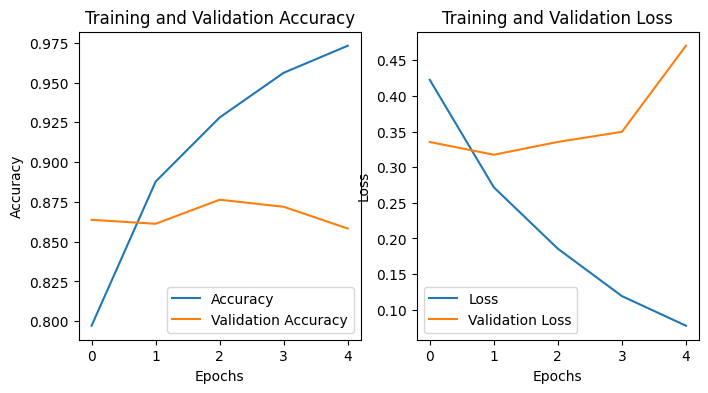

In [9]:
# Plotting the accuracy and loss over time

# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()


In [13]:
# Making predictions
sample_text = (
	'''Oh, the food was just amazing! If you enjoy waiting two hours for a cold meal that tastes like cardboard,  
	then this is definitely the place for you. The ambiance was perfect too,
	if you're into dimly lit rooms that make you feel like you're dining in a cave. Five stars for sure!'''
)
predictions = model.predict(np.array([sample_text]))
print(*predictions[0])

# Print the label based on the prediction
if predictions[0] > 0:
	print('The review is positive')
else:
	print('The review is negative')


1/1 [==============================] - 0s 338ms/step
1.267891
The review is positive
